<a href="https://colab.research.google.com/github/KarinkinK/personal_projects/blob/master/semantic_segmentation_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Загрузка датасета COCO и кода COCO API

In [ ]:
#!mkdir -p data

#!cd data && wget http://images.cocodataset.org/zips/train2017.zip 
# !cd data && wget http://images.cocodataset.org/zips/val2017.zip 
# !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 
  
#!cd data && unzip -q train2017.zip
# !cd data && unzip -q val2017.zip
# !cd data && unzip -q annotations_trainval2017.zip

# !cd data && git clone https://github.com/cocodataset/cocoapi
# !cd data/cocoapi/PythonAPI && make

--2020-08-07 16:32:26--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.12.44
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.12.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  16.6MB/s    in 18m 56s 

2020-08-07 16:51:23 (16.2 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]



### Импорт необходимых библиотек

In [ ]:
import os
import skimage.io as io
import numpy as np
from google.colab import drive
from pathlib import Path
import matplotlib.pyplot as plt

### Импорт TensorFlow

In [ ]:
import tensorflow as tf
%tensorflow_version 1.x
#tf.enable_eager_execution()
print('TensorFlow version:', tf.__version__)

TensorFlow is already loaded. Please restart the runtime to change versions.
TensorFlow version: 2.3.0


### Импорт библиотеки COCO API
Там содержатся различные функции для чтения и обработки датасета COCO

In [ ]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

### Наш класс Dataset
Этот класс конструирует экземпляры `tf.data.Dataset` и является универсальным для сегментации (подходит для использования с различными датасетами)

Однако, это абстрактный класс, в котром не реализован метод чтения датасета с диска, так как этот метод может отличаться для разных датасетов

In [ ]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)
        print('Images Count', len(self.img_list))

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

### Наш класс COCO_Dataset
Класс, наследованный от нашего класса `Dataset`, в котром реализован метод `read_images`, специфичный для датасета COCO

In [ ]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

### Создание обучающего и валидационного датасета
Сначала создаются два экземпляра класса `COCO_Dataset`, в конструкторе которого указывается тип датасета (указание для COCO - откуда какие читать изображения)

Далее вызываются функции `train_dataset` и `val_dataset` которые создают экземпляры `tf.data.Dataset`

In [ ]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

#train_ds = COCO_dataset_train.train_dataset(...)
#val_ds = COCO_dataset_val.val_dataset(...)

loading annotations into memory...
Done (t=26.51s)
creating index...
index created!
loading annotations into memory...
Done (t=0.95s)
creating index...
index created!


In [ ]:
#создание тренировочного датасета
train_ds = COCO_dataset_train.train_dataset(batch_size=32, epochs=2, inp_size=256)

Images Count 64115


In [ ]:
iterator = iter(train_ds)

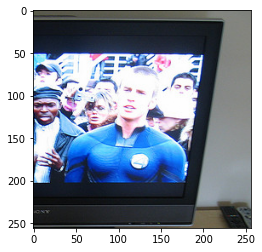

In [ ]:
img = iterator.get_next()
plt.imshow(img[0][0, ...])
plt.show()

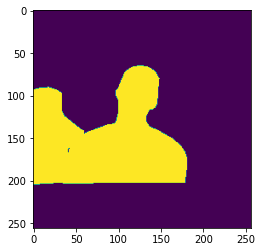

In [ ]:
plt.imshow(img[1][0, ..., 0])
plt.show()

In [ ]:
#создание валидационного датасета
val_ds = COCO_dataset_val.val_dataset(batch_size=10, inp_size=256)
iterator = iter(val_ds)

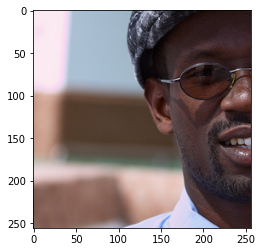

In [ ]:
img_v = iterator.get_next()
plt.imshow(img_v[0][0, ...])
plt.show()

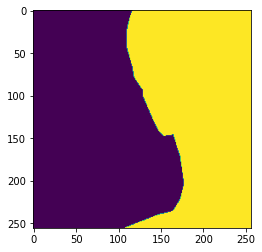

In [ ]:
plt.imshow(img_v[1][0, ..., 0])
plt.show()

### Создание модели нейронной сети для задачи семантический сегментации.

In [ ]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
#сохранение чекпоинта с лучшей моделью
path = Path("/content/drive/My Drive/My_model/model_FCN_ASPP")
#path = Path("/content/drive/My Drive/My_model/model_FCN")
path.mkdir(exist_ok=True, parents=True) 
assert path.exists()
cpt_filename = "best_checkpoint.hdf5"  
cpt_path = str(path / cpt_filename)

In [ ]:
# модель простой FCN для сравнения
# checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

# input = tf.keras.layers.Input((256, 256, 3))

# out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input)
# out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
# out = tf.keras.layers.MaxPool2D((2, 2))(out)
# out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
# out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
# out = tf.keras.layers.MaxPool2D((2, 2))(out)
# out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
# out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

# out = tf.keras.layers.UpSampling2D((2, 2))(out)
# out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
# out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
# out = tf.keras.layers.UpSampling2D((2, 2))(out)
# out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
# out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
# output = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

# model = tf.keras.Model(inputs=input, outputs=output)

# tf.keras.utils.plot_model(model, show_shapes=True)

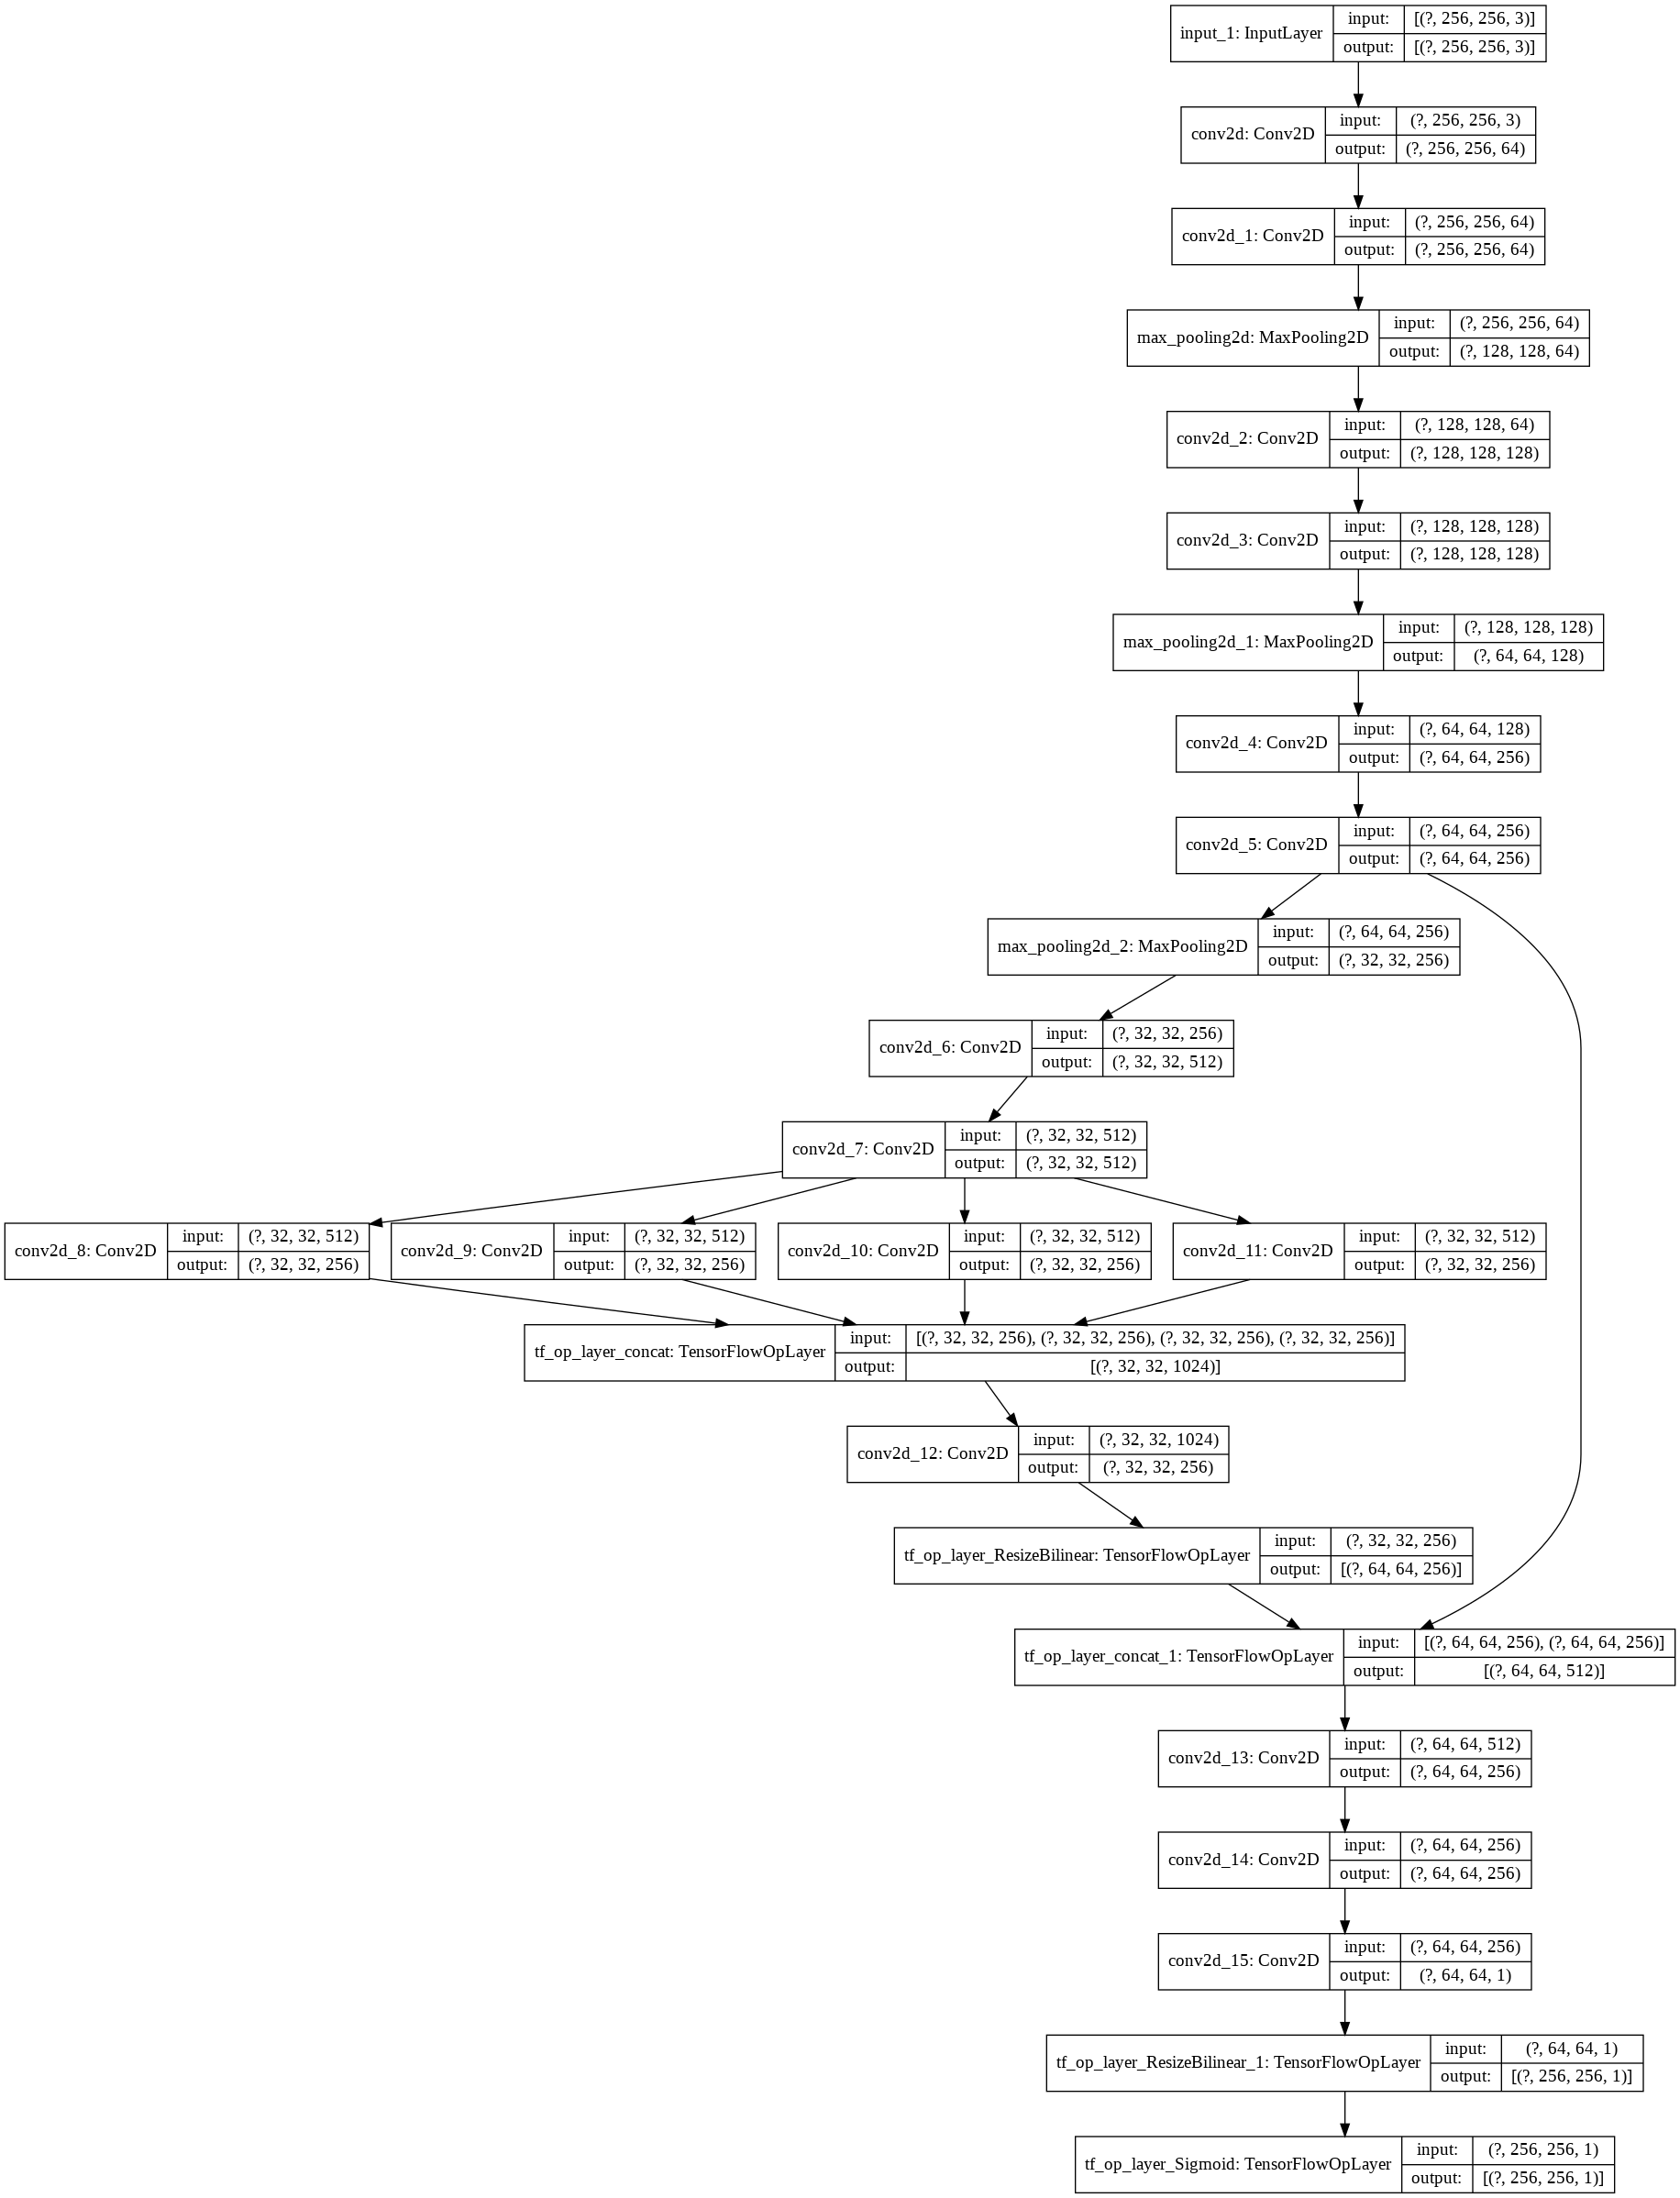

In [ ]:
#построение модели c ASPP блоком и одним skip-connection
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

input = tf.keras.layers.Input((256, 256, 3))
#encoder
out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input)
out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
out = tf.keras.layers.MaxPool2D((2, 2))(out)
out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
out = tf.keras.layers.MaxPool2D((2, 2))(out)
out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
out_enc = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
out = tf.keras.layers.MaxPool2D((2, 2))(out_enc)
out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

#ASPP block
out1 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')(out)
out2 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')(out)
out3 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')(out)
out4 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')(out)
out = tf.concat([out1, out2, out3, out4], axis=3)
out = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')(out)

#decoder
out = tf.image.resize(out, [64, 64], tf.image.ResizeMethod.BILINEAR)
out = tf.concat([out, out_enc], axis=3)
out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation=None)(out)
out = tf.image.resize(out, [256, 256], tf.image.ResizeMethod.BILINEAR)
output = tf.nn.sigmoid(out)

model = tf.keras.Model(inputs=input, outputs=output)

tf.keras.utils.plot_model(model, show_shapes=True)

Epoch 1/3
4007/4007 [==============================] - ETA: 0s - loss: 0.3306 - accuracy: 0.8476
Epoch 00001: accuracy improved from -inf to 0.84755, saving model to /content/drive/My Drive/My_model/model_FCN_ASPP/best_checkpoint.hdf5
4007/4007 [==============================] - 3704s 924ms/step - loss: 0.3306 - accuracy: 0.8476
Epoch 2/3
4007/4007 [==============================] - ETA: 0s - loss: 0.2464 - accuracy: 0.8923
Epoch 00002: accuracy improved from 0.84755 to 0.89235, saving model to /content/drive/My Drive/My_model/model_FCN_ASPP/best_checkpoint.hdf5
4007/4007 [==============================] - 3702s 924ms/step - loss: 0.2464 - accuracy: 0.8923
Epoch 3/3
4007/4007 [==============================] - ETA: 0s - loss: 0.2184 - accuracy: 0.9068
Epoch 00003: accuracy improved from 0.89235 to 0.90679, saving model to /content/drive/My Drive/My_model/model_FCN_ASPP/best_checkpoint.hdf5
4007/4007 [==============================] - 3716s 927ms/step - loss: 0.2184 - accuracy: 0.9068
C

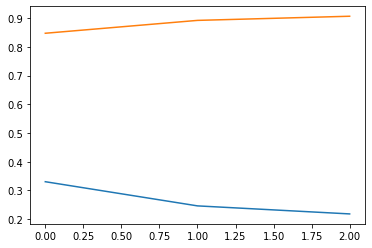

In [ ]:
#обучение модели
%%time
NUM_EPOCHS = 3
BATCH_SIZE = 1

loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

hist = model.fit(train_ds, epochs=NUM_EPOCHS, verbose=1, callbacks=[checkpoint])

plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])

In [ ]:
#значения лосса и точность на валидационной выборке val_ds
restored_model = tf.keras.models.load_model(cpt_path)
loss, acc = restored_model.evaluate(val_ds)
print(f"Accuracy of model {acc*100 :.2f}%, Loss of model {loss :.2f}")

269/269 [==============================] - 46s 172ms/step - loss: 0.2177 - accuracy: 0.9095
Accuracy of model 90.95%, Loss of model 0.22


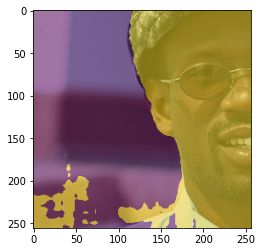

In [ ]:
#пример сегментации на случайном фото из валидационного датасета
out = restored_model.predict(img_v[0])
seg_map = (out[0, ..., 0]>0.5).astype(np.float32)
seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]
plt.imshow(img_v[0][0, ...]*0.5 + seg_map_clr*0.5)
plt.show()